# Are All the Cluster Tokens Equal?

We've identified 2,212 tokens in this weird dense cluster near the origin. They all have very similar norms and they're all packed together.

Hypothesis: Maybe they're all *literally the same vector*. Like, maybe during initialization, these tokens all got assigned to the exact same point in space and just... stayed there.

Let's find out.

## Parameters

In [5]:
# Paths
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'
GAMMA_PATH = '../tensors/Qwen3-4B-Instruct-2507/W.safetensors'

## Imports

In [6]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt

## Device Detection

In [7]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [8]:
# Load cluster token IDs from the adjacency graph analysis
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"Loaded {len(cluster_token_ids)} cluster token IDs")

Loaded 2212 cluster token IDs


In [9]:
# Load gamma matrix (unembedding matrix)
gamma_data = load_file(GAMMA_PATH)
W = gamma_data['W'].to(torch.float32).to(device)

print(f"Loaded gamma matrix: {W.shape}")

Loaded gamma matrix: torch.Size([151936, 2560])


In [10]:
# Extract the cluster vectors
cluster_vectors = W[cluster_token_ids]

print(f"Extracted {cluster_vectors.shape[0]} vectors of dimension {cluster_vectors.shape[1]}")

Extracted 2212 vectors of dimension 2560


## Test: Are They All Equal?

Simplest possible test: pick the first vector and see how many others are exactly equal to it.

In [11]:
# Pick first vector as reference
reference = cluster_vectors[0]

# Check exact equality for each vector
all_equal = torch.all(cluster_vectors == reference, dim=1)
num_equal = torch.sum(all_equal).item()

print(f"Vectors exactly equal to the first vector: {num_equal} / {len(cluster_vectors)}")
print(f"Percentage: {100 * num_equal / len(cluster_vectors):.1f}%")

if num_equal == len(cluster_vectors):
    print("\n✓ YES! All cluster tokens have the exact same vector.")
else:
    print(f"\n✗ NO. Only {num_equal} are equal; {len(cluster_vectors) - num_equal} are different.")

Vectors exactly equal to the first vector: 306 / 2212
Percentage: 13.8%

✗ NO. Only 306 are equal; 1906 are different.


## Follow-up: How Many Unique Vectors?

If they're not all identical, how many distinct vectors are there?

In [12]:
# Move to CPU for numpy operations
cluster_vectors_cpu = cluster_vectors.cpu().numpy()

# Find unique vectors (exact equality)
unique_vectors, inverse_indices, counts = np.unique(
    cluster_vectors_cpu,
    axis=0,
    return_inverse=True,
    return_counts=True
)

num_unique = len(unique_vectors)

print(f"Total cluster tokens: {len(cluster_vectors)}")
print(f"Unique vectors: {num_unique}")
print(f"Compression: {len(cluster_vectors) / num_unique:.1f}:1")

Total cluster tokens: 2212
Unique vectors: 125
Compression: 17.7:1


## How Many Tokens Share Each Vector?

Distribution of group sizes.

In [13]:
# Sort group sizes from largest to smallest
group_sizes = np.sort(counts)[::-1]

# How many vectors have multiple tokens vs just one?
num_duplicated = np.sum(counts >= 2)
num_unique_singletons = np.sum(counts == 1)

print(f"Vectors with 2+ tokens: {num_duplicated}")
print(f"Vectors with exactly 1 token: {num_unique_singletons}")
print(f"\nLargest group: {group_sizes[0]} tokens")
print(f"\nTop 20 group sizes:")
print(group_sizes[:20])

Vectors with 2+ tokens: 13
Vectors with exactly 1 token: 112

Largest group: 814 tokens

Top 20 group sizes:
[814 704 306 228  11  10   6   5   4   4   3   3   2   1   1   1   1   1
   1   1]


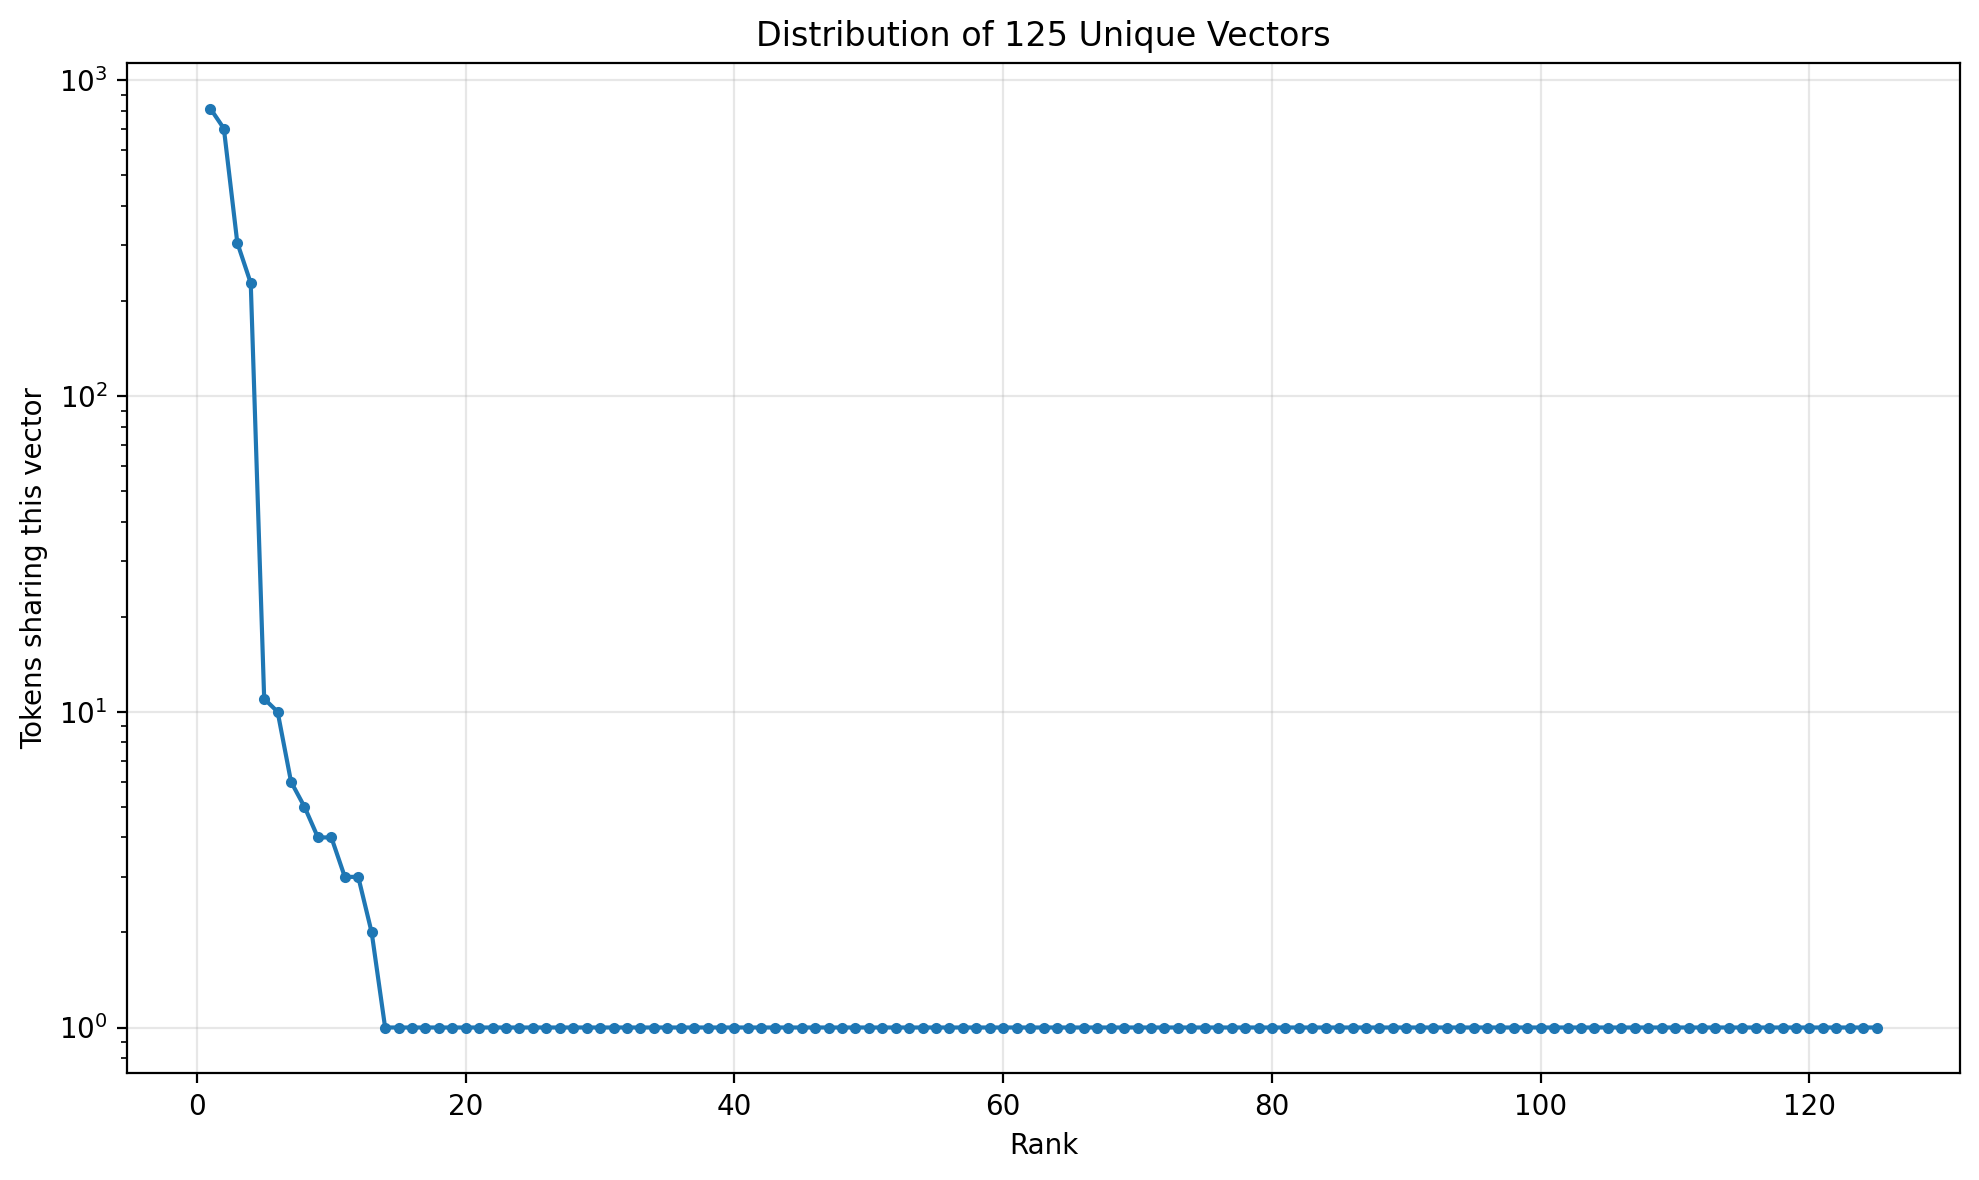

In [17]:
# Visualize the distribution
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

ax.plot(range(1, len(group_sizes) + 1), group_sizes, 'o-', markersize=3)
ax.set_xlabel('Rank')
ax.set_ylabel('Tokens sharing this vector')
ax.set_yscale('log')
ax.set_title(f'Distribution of {num_unique} Unique Vectors')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [18]:
print("="*60)
print("RESULTS")
print("="*60)
print(f"Total cluster tokens: {len(cluster_vectors)}")
print(f"Unique vectors: {num_unique}")
print(f"\nLargest group: {group_sizes[0]} tokens at the same point")
print(f"Vectors with duplicates: {num_duplicated}")
print(f"Vectors with no duplicates: {num_unique_singletons}")
print("\nConclusion:")
if num_unique == 1:
    print("  All 2,212 tokens point to the EXACT same location.")
elif num_unique < 50:
    print(f"  The cluster is made of {num_unique} distinct points.")
    print(f"  Most tokens ({group_sizes[0]}) are at one point.")
else:
    print(f"  The cluster contains {num_unique} different vectors.")
    print(f"  Not a singularity, but still very structured.")
print("="*60)

RESULTS
Total cluster tokens: 2212
Unique vectors: 125

Largest group: 814 tokens at the same point
Vectors with duplicates: 13
Vectors with no duplicates: 112

Conclusion:
  The cluster contains 125 different vectors.
  Not a singularity, but still very structured.
